In [1]:
from exp.nb_Tesis import *


In [4]:
# pip install --upgrade efficientnet-pytorch


In [5]:
urls2019 = ['https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip',
        'https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv']

In [6]:
# for idx,url in enumerate(urls2019):
#   !wget $url

In [7]:
# !unzip ISIC_2019_Training_Input.zip

In [17]:
min_dim = 450# 448

#2019
trainImagesFolderName = 'ISIC_2019_Training_Input'
smallTrainImagesFolderName = f'small_{min_dim}_ISIC_2019_Training_Input'
trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'
testImagesFolderName = 'ISIC2018_Task3_Test_Input'
smallTestImagesFolderName = f'small_{min_dim}_ISIC2018_Task3_Test_Input'

trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'

#2018
# trainImagesFolderName = 'ISIC2018_Task3_Training_Input'
# smallTrainImagesFolderName = f'small_{min_dim}_ISIC_2018_Training_Input'
# validImagesFolderName = 'ISIC2018_Task3_Validation_Input'
# trainingGroundTruthFileName2018 = 'ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'
# trainingGroundTruthFileName2019 = 'ISIC_2019_Training_GroundTruth.csv'
# smallTestImagesFolderName = f'small_{min_dim}_ISIC2018_Task3_Test_Input'




In [18]:
df = pd.read_csv(trainingGroundTruthFileName2019); print('# of images: ', len(df)); df.head()

# of images:  25331


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.head()


,image,label
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [20]:
#export
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
  
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

#### Prune the dataset if needed

In [23]:
!ls $smallTrainImagesFolderName | wc -l

25331


In [24]:
labels_exclusive_for_2019 = ['SCC']
training_for_2018 = True
max_of_each = 30
classDict = {}
images = get_image_files(smallTrainImagesFolderName)
newFolder = f'picked_{max_of_each}_{trainImagesFolderName}'
destFolder = Path(newFolder)
destFolder.mkdir(parents=True, exist_ok=True);

def prune_dataset(image,idx):
    label = get_label_for_image_path(image)
    if training_for_2018 and label in labels_exclusive_for_2019: return
    if label in classDict: classDict[label] = classDict[label] + 1
    else: classDict[label] = 1
    if classDict[label] < max_of_each:
        !cp './'$image $destFolder'/'
#         print(classDict[label],max_of_each)

parallel(partial(prune_dataset),images)
    

In [25]:
# destFolder = trainImagesFolderName

In [26]:
destFolder

PosixPath('picked_30_ISIC_2019_Training_Input')

#### Remove warnings

In [27]:
!nvidia-smi

Sat Mar 28 15:34:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
| 23%   27C    P8    15W / 250W |     12MiB / 11176MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [28]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [29]:
# torch.cuda.set_device(0)

## Load the dataset

In [30]:
!ls $destFolder | wc -l

3021


In [106]:
def reload_dataset(imgs_folder):
    random_seed(1,True)
    tfms = [*zoom_crop()]
    
    data = ImageList.from_folder(destFolder)\
    .split_by_rand_pct()\
    .label_from_func(get_label_for_image_path)\
    .transform(tfms)\
    .databunch(bs=16)\
    .normalize()
    return data

data = reload_dataset(destFolder)

In [197]:
[*zoom_crop(scale=(1.5,3), do_rand=True), *get_transforms()[0]]

[RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.5, 3), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'r

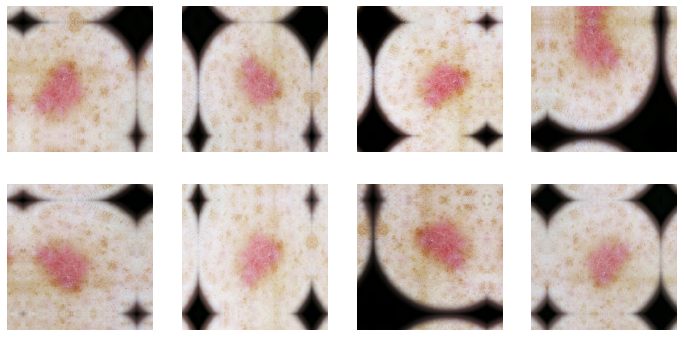

In [222]:
random_seed(1,True)

def get_ex(): return open_image(data.train_ds.x.items[1])

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]
    
# tfms = [[],[]]
tfms = [[*rand_resize_crop(352)
         , *get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.0,
                           max_lighting=0.2,p_affine=0,p_lighting=1, max_warp=0)[0]
        ]]
# tfms = [[*zoom_crop(scale=(1.3,3), do_rand=True)
#          , *get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.0,
#                            max_lighting=0.2,p_affine=0,p_lighting=1, max_warp=0)[0]
#         ]]
# tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.0
#                       , max_lighting=0.1,p_affine=0,p_lighting=0, max_warp=0)

# tfms[0].insert(0,rand_resize_crop(1)[0])

plots_f(2, 4, 12, 6)


In [140]:
get_transforms()

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

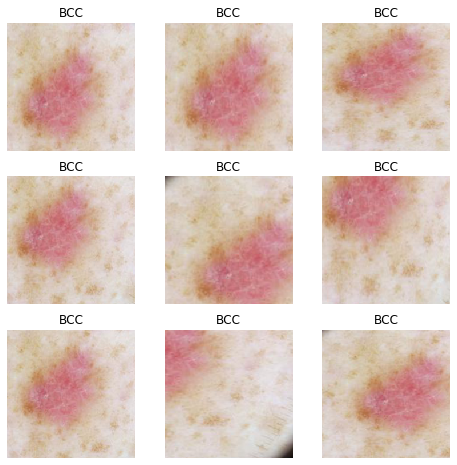

In [108]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [109]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 BCC     409
MEL     407
AK      403
BKL     396
NV      393
VASC    208
DF      193
dtype: int64 

 valid_count: 
 NV      111
BKL     107
AK      100
BCC      97
MEL      96
DF       46
VASC     45
dtype: int64
ratios:
AK      0.248139
BCC     0.237164
BKL     0.270202
DF      0.238342
MEL     0.235872
NV      0.282443
VASC    0.216346
dtype: float64 %


In [111]:
#export

# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

def get_class_weights(data):
    train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
    train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

    weighted_classes = [{c: (sum(train_count) / train_count[c] * len(data.classes))} for c in data.classes];
    print(weighted_classes)
    formatted_weights = [w[c] for c,w in zip(data.classes, weighted_classes) ]
    class_weights=torch.FloatTensor(formatted_weights).cuda()
    class_weights = class_weights / sum(class_weights)
    return class_weights

def train_learner(learner, name, epochs=8, lr=1e-3, wd = 1e-6, balanced=True,seed=1):
    if balanced: learner.loss_func = CrossEntropyFlat(weight = get_class_weights(learner.data))
    random_seed(seed,True)
    log_name = f'2019_imgsz_{learner.data.valid_ds[0][0].shape[1]}_{name}'
    print("Saving log on: ",log_name)
    learner.fit_one_cycle(epochs,max_lr=lr,wd=wd
                          ,callbacks = [
                            SaveModelCallback(learn=learner,name=log_name,monitor='accuracy'),
                            CSVLogger(learn=learner,filename=log_name),
                            ]
                         )

## Color correction

In [112]:
def max_rgb(image):
  # First get the maximum across the rows, then take the values and take the maximum again (this time dimension 1 will be the columns)
  return image.max(dim=1)[0].max(dim=1)[0]
  
def computeGrayWorldOnChannel(image, channel,p):
    I_cx = image[channel].sum()
    img_size = image[channel].shape.numel()
    return ( (I_cx ** p) / img_size )  ** (1/p) 

def shades_of_gray(img, p):
    n_channels, height, width  = img.shape
    iluminant = torch.zeros(3)
    for channel in range(n_channels):
        iluminant[channel] = computeGrayWorldOnChannel(img,channel,p)
    return iluminant

In [113]:
def correct_iluminant(estimated_iluminant):
    gamma = (torch.ones(3) / math.sqrt(3))
    corrected_iluminant = gamma * (1 / estimated_iluminant)
    return corrected_iluminant

def correct_image(image,estimated_iluminant):
    corrected_iluminant = correct_iluminant(estimated_iluminant)
    mat_iluminant = corrected_iluminant[:,None,None].expand(image.shape)
    c = mat_iluminant * image
    return c

In [114]:
def _correct_color_max_rgb(image):
    estimated_iluminant = max_rgb(image);

    c = correct_image(image,estimated_iluminant)
    return c

def _correct_color_shades_of_gray(image):
    estimated_iluminant = shades_of_gray(image,1);

    c = correct_image(image,estimated_iluminant)
    return torch.clamp(c,0,1)

correct_color_max_rgb = TfmPixel(_correct_color_max_rgb)
correct_color_shades_of_gray = TfmPixel(_correct_color_shades_of_gray)

# Training

First let's see the baseline result
* Images prerezised to: 352px

* get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1, max_warp=0)
* batch_size = 16
* random_seed 1
* epochs = 8 
* one_cycle_policy, max_lr = 1e-3, wd 1e-4
* balancing per class: True
* pretrained = True
* unfreezed = True
* Efficientnet-b4

train_count: 
 BKL     1276
NV      1262
BCC     1261
MEL     1255
AK       698
VASC     210
DF       194
dtype: int64 

 valid_count: 
 MEL     329
BCC     323
NV      322
BKL     308
AK      169
DF       45
VASC     43
dtype: int64
ratios:
AK      0.242120
BCC     0.256146
BKL     0.241379
DF      0.231959
MEL     0.262151
NV      0.255151
VASC    0.204762
dtype: float64 %

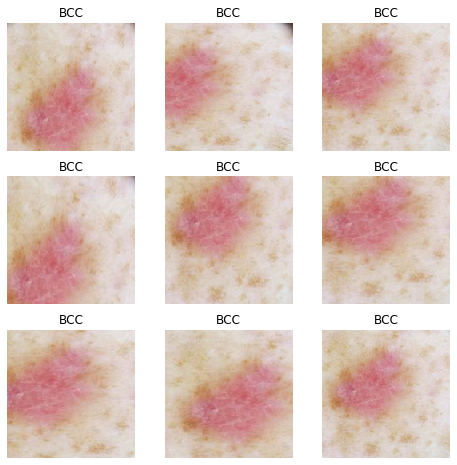

In [116]:
data = reload_dataset(destFolder)
plot_multi(_plot, 3, 3, figsize=(8,8))

# Insertamos en train como en valid ds, la correcion de color Max rgb en la primer posicion
# data.train_ds.tfms.insert(0,correct_color_max_rgb());
# data.valid_ds.tfms.insert(0,correct_color_max_rgb());
# plot_multi(_plot, 3, 3, figsize=(8,8))

In [121]:
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.model import MBConvBlock
from efficientnet_pytorch.utils import drop_connect
from torchvision.models.resnet import Bottleneck
import types

random_seed(1,True)

model_name = 'efficientnet-b3'
model_b3_arl = EfficientNet.from_pretrained(model_name)
model_b3_arl._fc = nn.Linear(1536, data.c) # si es b0 poner aca 1280, si es b3 poner 1536



Loaded pretrained weights for efficientnet-b3


In [122]:
alpha_initial_value = 0.001
    
def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._swish(self._bn0(self._expand_conv(inputs)))
        x = self._swish(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(self._swish(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs # skip connection
        return x
    
def add_attn_to_forward_func(a_module):
    a_module.forward = types.MethodType( forward,a_module)
    
def add_attn_params(a_module):
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
#     print(f'Added attention to {a_module}')
    
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, MBConvBlock): return
    add_attn_params(a_module)
    add_attn_to_forward_func(a_module)

In [123]:
# apply_leaf(model_b3_arl, change_basic_blocks)

In [124]:
mbconvs = [bn for bn in model_b3_arl.modules() if isinstance(bn,MBConvBlock)]

In [125]:
class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [126]:
learn_b3_arl = Learner(data,model_b3_arl,metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph
#                                   ,partial(Alphas, modules=mbconvs)
                                 ])
# learn_b0_arl.summary()

[{'AK': 41.84367245657568}, {'BCC': 41.229828850855746}, {'BKL': 42.58333333333333}, {'DF': 87.37305699481865}, {'MEL': 41.432432432432435}, {'NV': 42.908396946564885}, {'VASC': 81.07211538461539}]
Saving log on:  2019_imgsz_224_EfficientNet-b3


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.818545,1.794752,0.666113,0.333887,0.457017,00:31
1,1.491553,1.386327,0.544850,0.455150,0.550046,00:30
2,1.246722,1.172318,0.473422,0.526578,0.531408,00:30
3,1.106512,1.090996,0.440199,0.559801,0.448607,00:31
4,1.036299,1.148185,0.451827,0.548173,0.464836,00:30
5,0.984300,1.259259,0.463455,0.536545,0.422925,00:31
6,0.940893,1.405985,0.498339,0.501661,0.552700,00:31
7,0.887561,1.598860,0.504983,0.495017,0.463673,00:30
8,0.940671,1.345806,0.476744,0.523256,0.461488,00:31
9,0.900697,1.905206,0.584718,0.415282,0.416250,00:31


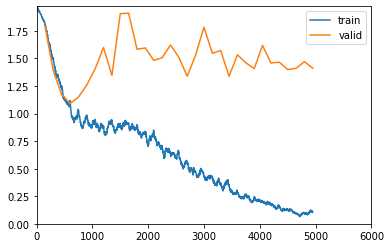

Better model found at epoch 0 with accuracy value: 0.3338870406150818.
Better model found at epoch 1 with accuracy value: 0.45514950156211853.
Better model found at epoch 2 with accuracy value: 0.5265780687332153.
Better model found at epoch 3 with accuracy value: 0.5598006844520569.
Better model found at epoch 17 with accuracy value: 0.5863787531852722.
Better model found at epoch 22 with accuracy value: 0.6328903436660767.
Better model found at epoch 31 with accuracy value: 0.6461793780326843.


KeyboardInterrupt: 

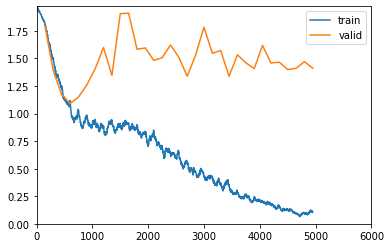

In [128]:
train_learner(learn_b3_arl,'EfficientNet-b3',lr=9.12E-04,epochs=40)

In [51]:
Tiene que llegar cerca de .80 accuracy

PosixPath('small_224_ISIC_2018_Training_Input')

In [52]:
learn_b4_arl.save('submitter_end')

In [53]:
learn_b4_arl.load('bestacc')

Learner(data=ImageDataBunch;

Train: LabelList (8012 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NV,NV,VASC,AKIEC,NV
Path: small_224_ISIC_2018_Training_Input;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NV,DF,BKL,NV,MEL
Path: small_224_ISIC_2018_Training_Input;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1,

[{'AK': 61.73638968481375}, {'BCC': 34.172878667724035}, {'BKL': 33.77115987460815}, {'DF': 222.1237113402062}, {'MEL': 34.33625498007969}, {'NV': 34.14580031695721}, {'VASC': 205.2}]
Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.591217,0.675017,0.298246,0.701754,0.619241,03:43
1,0.462282,0.642984,0.286550,0.713450,0.621481,03:44
2,0.329490,0.649656,0.269006,0.730994,0.571421,03:44
3,0.629382,0.650329,0.269656,0.730344,0.572735,03:44


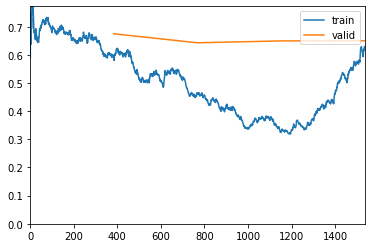

Better model found at epoch 0 with accuracy value: 0.7017543911933899.
Better model found at epoch 1 with accuracy value: 0.7134503126144409.
Better model found at epoch 2 with accuracy value: 0.7309941649436951.


In [35]:
train_learner(learn_b4_arl,'EfficientNet-b0',lr=9.12E-05,wd=9.12E-07, epochs=4)

In [54]:
#export
def plot_conf_matrix(interpretation):
    interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)
    print("Balanced accuracy: ", get_balanced_accurracy(interpretation))
    plt.tight_layout()

def get_balanced_accurracy(interpretation):
    matrix = interpretation.confusion_matrix()
    balanced_acc = 0
    for i in range(len(matrix[0])):
        row = matrix[i]
        correctGuesses = row[i]
        allPossibleTries = row.sum()
        classAcurracy = correctGuesses / allPossibleTries
        balanced_acc += classAcurracy
    balanced_acc /= len(matrix[0])
    return balanced_acc



Balanced accuracy:  0.7532747135525799


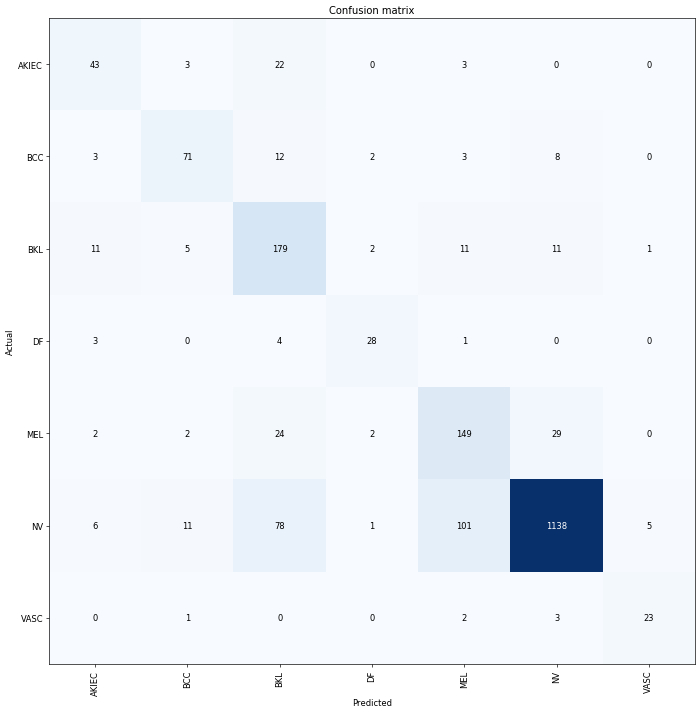

In [55]:
interp_b4_arl = ClassificationInterpretation.from_learner(learn_b4_arl)

plot_conf_matrix(interp_b4_arl)
plt.tight_layout()

In [92]:
interp_b4_arl.confusion_matrix()

array([[  43,    3,   22,    0,    3,    0,    0],
       [   3,   71,   12,    2,    3,    8,    0],
       [  11,    5,  179,    2,   11,   11,    1],
       [   3,    0,    4,   28,    1,    0,    0],
       [   2,    2,   24,    2,  149,   29,    0],
       [   6,   11,   78,    1,  101, 1138,    5],
       [   0,    1,    0,    0,    2,    3,   23]])

[{'AK': 61.73638968481375}, {'BCC': 34.172878667724035}, {'BKL': 33.77115987460815}, {'DF': 222.1237113402062}, {'MEL': 34.33625498007969}, {'NV': 34.14580031695721}, {'VASC': 205.2}]
Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.350442,0.643963,0.272904,0.727096,0.571269,03:43
1,0.254470,0.652003,0.264457,0.735543,0.559053,03:43
2,0.239403,0.667162,0.268356,0.731644,0.553849,03:44
3,0.630522,0.668562,0.268356,0.731644,0.554752,03:44


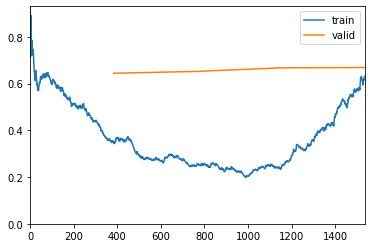

Better model found at epoch 0 with accuracy value: 0.7270955443382263.
Better model found at epoch 1 with accuracy value: 0.7355425357818604.


In [38]:
train_learner(learn_b4_arl,'EfficientNet-b0',lr=9.12E-06,wd=9.12E-08, epochs=4)

In [64]:
small_224_ISIC_2018_Training_Input/

'ISIC2018_Task3_Training_Input'

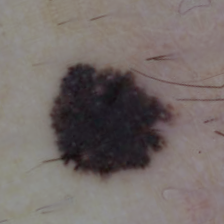

In [85]:
learn_b4_arl.data.train_ds[5][0]

In [62]:
!ls $smallTestImagesFolderName |wc -l

1512


In [66]:
learn_test = load_learner(path='small_224_ISIC_2018_Training_Input',file='ja',test=ImageList.from_folder(smallTestImagesFolderName))

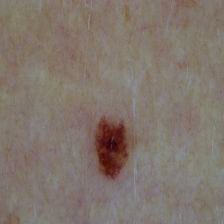

In [77]:
learn_test.data.test_ds[2][0]

In [68]:
preds, y = learn_test.TTA(ds_type=DatasetType.Test, beta=0.4, scale=1.35)


In [69]:
cols = ['image'] + learn_test.data.classes


predictions = []
for idx, filePath in enumerate(learn_test.data.test_ds.items):
    row = {}
    current_pred = preds[idx]
    row['image'] = filePath.name.replace('.jpg','')
    for idx2, cat in enumerate(learn_test.data.classes):
        row[cat] = current_pred[idx2].item()

    predictions.append(row)

predictionsDf = pd.DataFrame(predictions, columns=cols);



print(len(predictionsDf))
predictionsDf = predictionsDf.rename(columns={'AK':'AKIEC'})
predictionsDf.head()
predictions_csv_path = f'learn_test_b4_arl.csv'
predictionsDf.to_csv(predictions_csv_path, index=False)

1512
